# Download dependencies and data (Do not run if data is already downloaded)

In [30]:
!pip install kaggle

^C


In [ ]:
#login to kaggle via cli to download the dataset
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
import json

username = "<your-username>"
key = "<your-key>"
dict = {"username":username,"key":key}
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(dict, file)

In [ ]:
#download the dataset
!kaggle competitions download -c hku-comp3314-2024-1a-a3-image-classification-challenge

In [ ]:
#unzip the dataset
!unzip hku-comp3314-2024-1a-a3-image-classification-challenge.zip

# Data Analysis and Visualization

In [145]:
#import required libraries for this section
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [146]:
# Load training data
train_df = pd.read_csv('train.csv')  
print('Training data shape:', train_df.shape)
print('Examples of training data:')
print(train_df.head(6))
print('\n')

# Load test data
test_df = pd.read_csv('test.csv') 
print('Test data shape:', test_df.shape)
print('Examples of test data:')
print(test_df.head(6))

Training data shape: (50000, 2)
Examples of training data:
       im_name  label
0  00016cd.jpg      6
1  0001808.jpg      2
2  0002399.jpg      1
3  0003973.jpg      3
4  00061cc.jpg      4
5  0007365.jpg      5


Test data shape: (10000, 2)
Examples of test data:
       im_name  label
0  d59d350.jpg      0
1  d59e3e9.jpg      0
2  d59e68e.jpg      0
3  d59ef00.jpg      0
4  d59f154.jpg      0
5  d59fa50.jpg      0


In [147]:
# Display dataset statistics
category_counts = train_df['label'].value_counts().sort_index()
category_counts

label
0    5010
1    5012
2    5038
3    5007
4    4995
5    4993
6    4955
7    5000
8    5020
9    4970
Name: count, dtype: int64

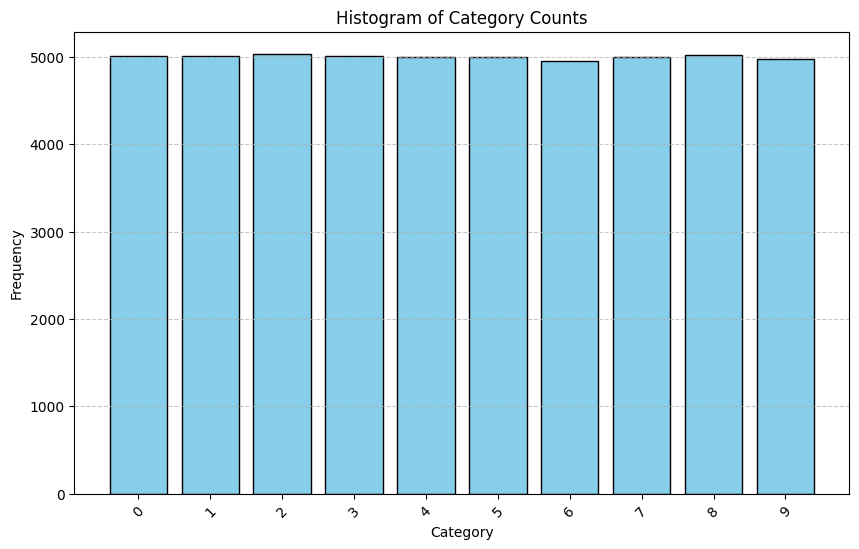

In [148]:
category_counts_df = pd.DataFrame(list(category_counts.items()), columns=['Category', 'Frequency'])

# Plot histogram
plt.figure(figsize=(10, 6))
plt.bar(category_counts_df['Category'], category_counts_df['Frequency'], color='skyblue', edgecolor='black')
plt.title("Histogram of Category Counts")
plt.xlabel("Category")
plt.ylabel("Frequency")
plt.xticks(ticks=category_counts_df['Category'], labels=category_counts_df['Category'], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

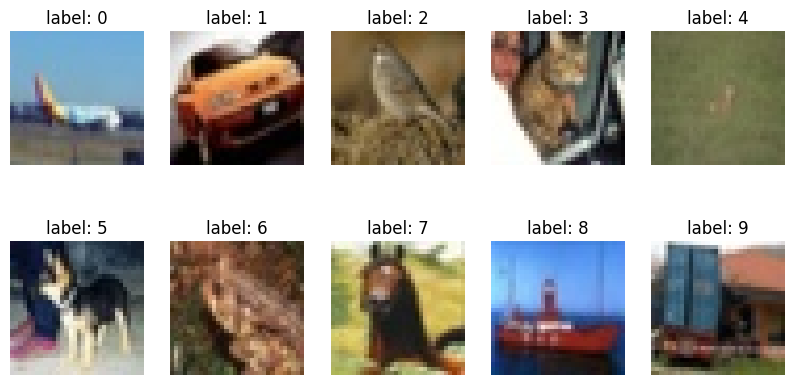

In [149]:
#randomly select one of each image from 10 labels and display them
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))

for label in range(10):
    img_path = train_df[train_df['label'] == label].sample(1)['im_name'].values[0]
    img = plt.imread(f'train_ims/{img_path}')
    ax = axes[label//5, label%5]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'label: {label}')

# Classifier Exploration

In [ ]:
#import required libraries for this section
import cv2
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns

### Prepare the data for training

In [ ]:
#define accuracy function
def get_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

In [ ]:
# define the function to flatten the image
def flatten_image(image_path):
    # Load the image
    img = cv2.imread(image_path)
    
    # Resize the image
    img = cv2.resize(img, (64, 64))
    
    # Flatten the image to a 1D vector
    return img.flatten()

In [ ]:
# Function to train PCA on a dataset
def train_pca(flat_images, n_components=32):
    pca = PCA(n_components=n_components)
    pca.fit(flat_images)
    return pca

In [ ]:
#Encode the image to numerical values
image_paths = train_df['im_name'].values
image_paths = [f'train_ims/{path}' for path in image_paths]
labels = train_df['label'].values

# Load and flatten all images
flat_images = np.array([flatten_image(img) for img in image_paths])

# Train PCA on the flattened images
pca = train_pca(flat_images, n_components=64)

# Transform all images using PCA
X = pca.transform(flat_images)

In [ ]:
# define Y variable
Y = labels

In [ ]:
# Split the dataset into training and testing sets for internal validation
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

In [ ]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(40000, 64) (10000, 64) (40000,) (10000,)


### Comparing each algorithm

Kernel SVM

In [ ]:
C_list = [0.01, 0.1, 1, 8]
accuracy = []
for c in C_list:
    svm_model = SVC(kernel='rbf', C = c, gamma='scale', random_state=42)  # RBF kernel with hyperparameter tuning
    svm_model.fit(X_train, Y_train)

    Y_pred = svm_model.predict(X_test)

    print(f"Accuracy when C = {c}:", get_accuracy(Y_test, Y_pred))
    accuracy.append(get_accuracy(Y_test, Y_pred))

print('\n')
print(f'the best accuracy is when C = {C_list[accuracy.index(max(accuracy))]} with score = {max(accuracy)}')

Accuracy when C = 0.01: 0.3496
Accuracy when C = 0.1: 0.4442
Accuracy when C = 1: 0.5149
Accuracy when C = 8: 0.536


the best accuracy is when C = 8 with score = 0.536


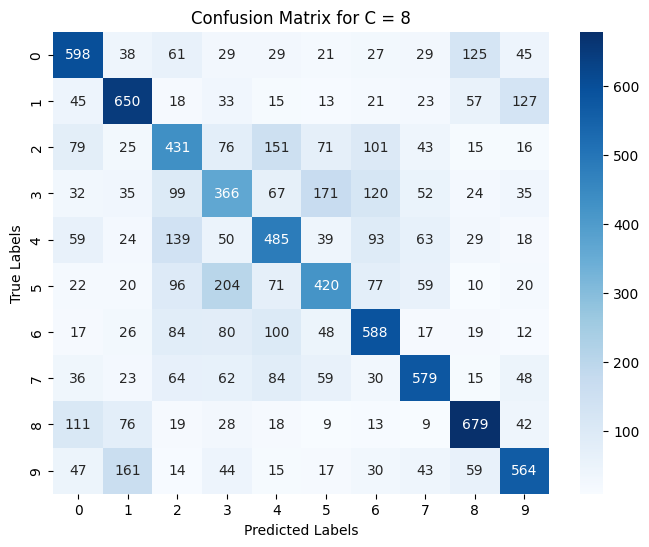

In [ ]:
# create a confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=set(Y_test), yticklabels=set(Y_test))
plt.title(f"Confusion Matrix for C = {8}")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Random Forest

In [29]:
N_list = [50, 100, 500, 750]
accuracy = []
for n in N_list:
    rf_model = RandomForestClassifier(n_estimators=n, random_state=42)  # Random Forest with hyperparameter tuning
    rf_model.fit(X_train, Y_train)

    Y_pred = rf_model.predict(X_test)

    print(f"Accuracy when N = {n}:", get_accuracy(Y_test, Y_pred))

    accuracy.append(get_accuracy(Y_test, Y_pred))

print('\n')
print(f'the best accuracy is when n_estimators = {N_list[accuracy.index(max(accuracy))]} with score = {max(accuracy)}')

Accuracy when N = 50: 0.4339
Accuracy when N = 100: 0.461
Accuracy when N = 500: 0.4924


KeyboardInterrupt: 

In [ ]:
# create a confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=set(Y_test), yticklabels=set(Y_test))
plt.title(f"Confusion Matrix for N = {750}")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Logistic Regression

In [ ]:
C_list = [0.01, 0.1, 10, 100, 1]
for c in C_list:
    lr_model = LogisticRegression(C=c, random_state=42, max_iter = 500)  # Logistic Regression with hyperparameter tuning
    lr_model.fit(X_train, Y_train)

    Y_pred = lr_model.predict(X_test)

    print(f"Accuracy when C = {c}:", get_accuracy(Y_test, Y_pred))

    accuracy.append(get_accuracy(Y_test, Y_pred))

print('\n')
print(f'the best accuracy is when C = {C_list[accuracy.index(max(accuracy))]} with score = {max(accuracy)}')

/home/innowing-391/anaconda3/envs/social/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy when C = 0.01: 0.3849


/home/innowing-391/anaconda3/envs/social/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy when C = 0.1: 0.3844


/home/innowing-391/anaconda3/envs/social/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy when C = 10: 0.3848


/home/innowing-391/anaconda3/envs/social/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy when C = 100: 0.3842
Accuracy when C = 1: 0.3845


the best accuracy is when C = 0.01 with score = 0.385


/home/innowing-391/anaconda3/envs/social/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


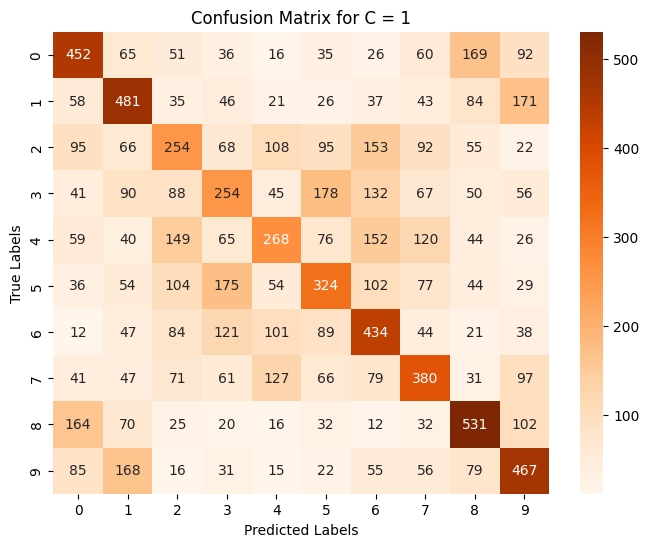

In [ ]:
# create a confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Oranges", xticklabels=set(Y_test), yticklabels=set(Y_test))
plt.title(f"Confusion Matrix for C = {1}")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### KNN

In [ ]:
N_list = [1, 3, 5, 7, 9, 12, 20, 15]
accuracy = []
for n in N_list:
    knn_model = KNeighborsClassifier(n_neighbors=n, p=2, metric='minkowski')  # KNN with hyperparameter tuning
    knn_model.fit(X_train, Y_train)

    Y_pred = knn_model.predict(X_test)

    print(f"Accuracy when N = {n}:", get_accuracy(Y_test, Y_pred))

    accuracy.append(get_accuracy(Y_test, Y_pred))

print('\n')
print(f'the best accuracy is when n_estimators = {N_list[accuracy.index(max(accuracy))]} with score = {max(accuracy)}')

Accuracy when N = 1: 0.3746
Accuracy when N = 3: 0.3648
Accuracy when N = 5: 0.3813
Accuracy when N = 7: 0.3829
Accuracy when N = 9: 0.3889
Accuracy when N = 12: 0.3871
Accuracy when N = 20: 0.384
Accuracy when N = 15: 0.3894


the best accuracy is when n_estimators = 15 with score = 0.3894


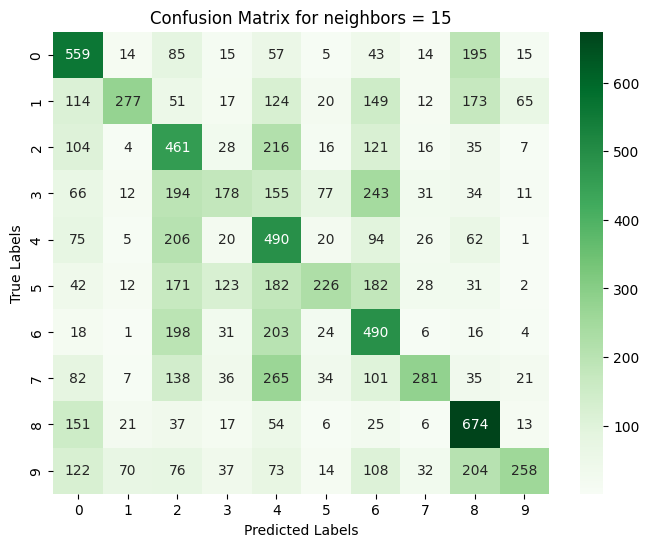

In [ ]:
# create a confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=set(Y_test), yticklabels=set(Y_test))
plt.title(f"Confusion Matrix for neighbors = {15}")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Ensemble Learning

In [ ]:
#select best parameter of each model
clf1 = SVC(kernel='rbf', C=8, random_state=0) #SVM
clf2 = RandomForestClassifier(n_estimators=750, random_state=42) #Random Forest
clf3 = LogisticRegression(C=1, random_state=42) # Logistic Regression
clf4 = KNeighborsClassifier(n_neighbors=12, p=2, metric='minkowski') #KNN
pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe2 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf4]])
pipe4 = Pipeline([['sc', StandardScaler()], ['clf', clf2]])
clf_labels = ['SVM (10)', 'Random Forest (750)', 'Logistic Regression (1)', 'KNN (12)']

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y):
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel' ; got (vote=%r)" % self.vote)
        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers' % (len(self.weights), len(self.classifiers)))
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)       
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(
                       lambda x: np.argmax(np.bincount(x, weights=self.weights)), axis=1, arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

In [ ]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, pipe2, pipe3, pipe4]) # create Majority Voting Classifier

mv_clf.fit(X_train, Y_train) # fit the model

y_pred = mv_clf.predict(X_test) # predict the test data

print('Majority voting accuracy:', get_accuracy(Y_test, y_pred)) # print the accuracy

### To conclude, Kernel SVM outperforms other model in term of accuracy

# Final Solution

Methodology:
1. We split the train data into 40,000 rows of training set and 10,000 rows of validation set. This is for internal obeservation to determine which ML algorithm and feature extractions techniques work the best.
2. After achieving satisfactory result, we will retrain the whole 50,000 rows of the data with the same method. Then we label the test data and submit through kaggle

In [169]:
#import required libraries for this section
import cv2
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

## Step 1 (internal tuning)

In [170]:
#get evaluation metrics
def get_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

Split for only observing accuracy purpose

In [171]:
# Split the dataset into training and testing sets
X = train_df['im_name']
Y = train_df['label']

X_train_path, X_test_path, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y) # split the data

Prepare data (Hog feature extraction and PCA)

In [172]:
#function to extract hog features
def extract_hog_features(image):
    # Initialize HOG descriptor with the best parameters we have tested.
    hog = cv2.HOGDescriptor(
        _winSize = (64,64),
        _blockSize = (32,32),
        _blockStride = (16,16),
        _cellSize = (8,8),
        _nbins = 12,
        _derivAperture=1,
        _winSigma=-1,
        _histogramNormType=0,
        _L2HysThreshold=0.2,
        _gammaCorrection=True,
        _nlevels=1,
        _signedGradient=True
)
    hog_features = hog.compute(image)
    return hog_features.flatten()

#function to include color channels in the feature extraction
def extract_color_hog_features(image_path):
    # Read image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Image {image_path} could not be loaded.")
        return None
    # Resize image to a fixed size (32x32)
    image = cv2.resize(image, (64, 64))
    # Split the image into its color channels
    channels = cv2.split(image)
    hog_features = []
    for channel in channels:
        features = extract_hog_features(channel)
        hog_features.append(features)
    # Concatenate HOG features from all channels
    hog_features = np.concatenate(hog_features)
    return hog_features

In [173]:
#function to train pca for reduce dimensionality
def train_pca(flat_images, n_components):
    pca = PCA(n_components=n_components)
    pca.fit(flat_images)
    return pca

In [174]:
X_total = np.array([extract_color_hog_features(f'train_ims/{img}') for img in X]) #define X_total to train better pca (more data)
X_train_features = np.array([extract_color_hog_features(f'train_ims/{img}') for img in X_train_path]) #extract features for training data
X_test_features = np.array([extract_color_hog_features(f'train_ims/{img}') for img in X_test_path]) #extract features for testing data
print(X_total.shape, X_train_features.shape, X_test_features.shape)

(50000, 5184) (40000, 5184) (10000, 5184)


In [175]:
pca = train_pca(X_total, n_components=306) #train pca with X_total

#get explained variance ratio (optimal is 0.8-0.85 to avoid overfitting)
print(sum(pca.explained_variance_ratio_))

0.8486937548732385


In [176]:
# reduce the dimensionality of the features for training
X_train = pca.transform(X_train_features)
X_test = pca.transform(X_test_features)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(40000, 306) (10000, 306) (40000,) (10000,)


Train the model (SVC with C=8)

In [177]:
svm_model = SVC(kernel='rbf', C = 8, gamma='scale', random_state=42)
svm_model.fit(X_train, Y_train)

Y_pred = svm_model.predict(X_test)

print(f"Accuracy when C = {8}:", get_accuracy(Y_test, Y_pred))

Accuracy when C = 8: 0.7289


In [179]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, Y_pred)

array([[779,  14,  54,  25,  17,   7,   9,  14,  59,  24],
       [ 22, 846,  10,  10,  12,   5,  12,   3,  28,  54],
       [ 72,  17, 603,  82,  76,  54,  48,  33,  21,   2],
       [ 37,  12,  70, 542,  52, 151,  54,  44,  16,  23],
       [ 35,  15,  56,  80, 676,  46,  26,  42,  13,  10],
       [ 11,   7,  55, 174,  61, 598,  37,  45,   6,   5],
       [ 10,  12,  51,  71,  28,  19, 778,   3,  18,   1],
       [ 14,   3,  36,  45,  61,  49,   7, 776,   2,   7],
       [ 51,  28,  15,  15,   5,   2,   3,   5, 864,  16],
       [ 23,  46,  11,  19,  16,   8,   7,  13,  24, 827]])

## Step 2: Full training

prepare real train set

In [160]:
X = train_df['im_name']

X_train = X #use all data for training
X_train_features = np.array([extract_color_hog_features(f'train_ims/{img}') for img in X_train]) #extract features for all data
X_train = pca.transform(X_train_features) #reduce dimensionality of all data (same trained pca as the one we use in step 1)

In [161]:
Y = train_df['label']
Y_train = Y

In [162]:
print(X_train.shape, Y_train.shape)

(50000, 300) (50000,)


In [163]:
from sklearn.svm import SVC
svm_model = SVC(kernel='rbf', C = 8, gamma='scale', random_state=42)  # RBF kernel with hyperparameter tuning
svm_model.fit(X_train, Y_train)

SVC(C=8, random_state=42)

Prepare real test set

In [164]:
#create test set from test_df
image_paths = test_df['im_name'].values
image_paths = [f'test_ims/{path}' for path in image_paths]

# Load and flatten all images
feature_extracted_images = np.array([extract_color_hog_features(img_path) for img_path in image_paths])

real_X_test = pca.transform(feature_extracted_images) #same pca for train_set data

print(real_X_test.shape)

(10000, 300)


In [165]:
y_pred = svm_model.predict(real_X_test)

Submit to kaggle

In [166]:
#create submission.csv with im_name same as test_df and label as y_pred
submission = pd.DataFrame({'im_name': test_df['im_name'], 'label': y_pred})
submission.head(6)

,im_name,label
0,d59d350.jpg,2
1,d59e3e9.jpg,9
2,d59e68e.jpg,8
3,d59ef00.jpg,7
4,d59f154.jpg,9
5,d59fa50.jpg,6


In [167]:
#save submission dataframe to csv
submission.to_csv('submission.csv', index=False)

In [168]:
#uncomment and run this to submit the csv file to kaggle
!kaggle competitions submit -c hku-comp3314-2024-1a-a3-image-classification-challenge -f submission.csv -m "Eighteenth try"

100%|█████████████████████████████████████████| 137k/137k [00:01<00:00, 117kB/s]
Successfully submitted to HKU COMP3314 A3 Image Classification Challenge